In [1]:
import intake
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
import pandas as pd

col_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(col_url)
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [2]:
query = col.search(
    experiment_id="historical",
    table_id="SImon",
    variable_id=["siu", "siv", "siconc"],
    member_id="r1i1p1f1",
    grid_label="gn"
    #time_range=("2000-01-01", None)
)

print(query.df.head())

dset_dict = query.to_dataset_dict(
    zarr_kwargs={'consolidated': True},
    xarray_combine_by_coords_kwargs={'compat': 'override'}
)

  activity_id institution_id     source_id experiment_id member_id table_id  \
0        CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1    SImon   
1        CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1    SImon   
2        CMIP      NOAA-GFDL      GFDL-CM4    historical  r1i1p1f1    SImon   
3        CMIP           IPSL  IPSL-CM6A-LR    historical  r1i1p1f1    SImon   
4        CMIP           IPSL  IPSL-CM6A-LR    historical  r1i1p1f1    SImon   

  variable_id grid_label                                             zstore  \
0         siu         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
1         siv         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
2      siconc         gn  gs://cmip6/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/histo...   
3      siconc         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   
4         siu         gn  gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/histor...   

   dcpp_init_year   version  
0             NaN  2

In [3]:
query['model'] = query.df.apply(
    lambda row: f"CMIP.{row['institution_id']}.{row['source_id']}.{row['experiment_id']}.{row['table_id']}.{row['grid_label']}",
    axis=1
)

model_names = query['model'].unique()

print("models in  query:")
for model_name in model_names:
    print(f'MODEL: {model_name}')
    ds = dset_dict[model_name]

    #print(f"Dataset: {ds}")
    print(ds.data_vars)
    print(ds.coords)

models in  query:
MODEL: CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gn
Data variables:
    siconc   (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 60, 1080, 1440), meta=np.ndarray>
    siu      (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 42, 1080, 1440), meta=np.ndarray>
    siv      (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 41, 1080, 1440), meta=np.ndarray>
Coordinates:
  * bnds            (bnds) float64 1.0 2.0
    lat             (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lat_bnds        (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
    lon             (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
    lon_bnds        (y, x, vertex) float32 dask.array<chunksize=(1080, 1440, 4), meta=np.ndarray>
  * time            (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bnds       (time, bnds) object da

In [7]:
model = 'CMIP.IPSL.IPSL-CM6A-LR-INCA.historical.SImon.gn'
ds = dset_dict[model]

#print(f"Dataset: {ds}")
print(ds.data_vars)
print(ds.coords)

Data variables:
    siconc   (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 705, 332, 362), meta=np.ndarray>
    siu      (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 812, 332, 362), meta=np.ndarray>
    siv      (member_id, dcpp_init_year, time, y, x) float32 dask.array<chunksize=(1, 1, 800, 332, 362), meta=np.ndarray>
Coordinates:
    area            (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    bounds_nav_lat  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    bounds_nav_lon  (y, x, nvertex) float32 dask.array<chunksize=(332, 362, 4), meta=np.ndarray>
    nav_lat         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
    nav_lon         (y, x) float32 dask.array<chunksize=(332, 362), meta=np.ndarray>
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T...
    time_bounds     (time, axis_nbounds) datetime64[ns] dask.array<chunksiz

In [ ]:
#time filter
time = ds['time'].data

if isinstance(time[0], cftime.datetime):
    time_mask = time >= cftime.DatetimeNoLeap(2000, 1, 1)
else:
    time_mask = time >= np.datetime64('2000-01-01')

ds_filtered_time = ds.sel(time=time_mask)

#latitude filter 
lat = ds.nav_lat
lat = lat.compute()
mask = lat >= 75
ds_north_75 = ds_filtered_time.where(mask, drop=True)

if 'siu' in ds_north_75.data_vars and 'siv' in ds_north_75.data_vars and 'siconc' in ds_north_75.data_vars:
    condition = (
        (ds_north_75['siconc'] > 0) &  
        (ds_north_75['siu'] != 0) &   
        (ds_north_75['siv'] != 0)    
    )
    condition = condition.compute()

    ds_filtered = ds_north_75.where(condition, drop=True)

    # Calculate sea ice velocity magnitude
    velocity_magnitude = np.sqrt(ds_filtered['siu']**2 + ds_filtered['siv']**2)

    # 'area' variable
    if 'area' in ds_filtered:
        area = ds_filtered['area']
    else:
        area = xr.ones_like(velocity_magnitude)

    # area-averaged sea ice velocity
    area_weighted_velocity = (
        (velocity_magnitude * area).sum(dim=['y', 'x']) /
        area.sum(dim=['y', 'x'])
    )

    area_weighted_velocity.plot()
    plt.title('Area-Averaged Sea Ice Velocity North of 75° Latitude')
    plt.ylabel('Sea Ice Velocity (m/s)')
    plt.xlabel('Time')
    plt.show()

Processing model: CMIP.NASA-GISS.GISS-E2-1-H.historical.SImon.gn
hello
Variables not found in model
Processing model: CMIP.IPSL.IPSL-CM6A-LR-INCA.historical.SImon.gn


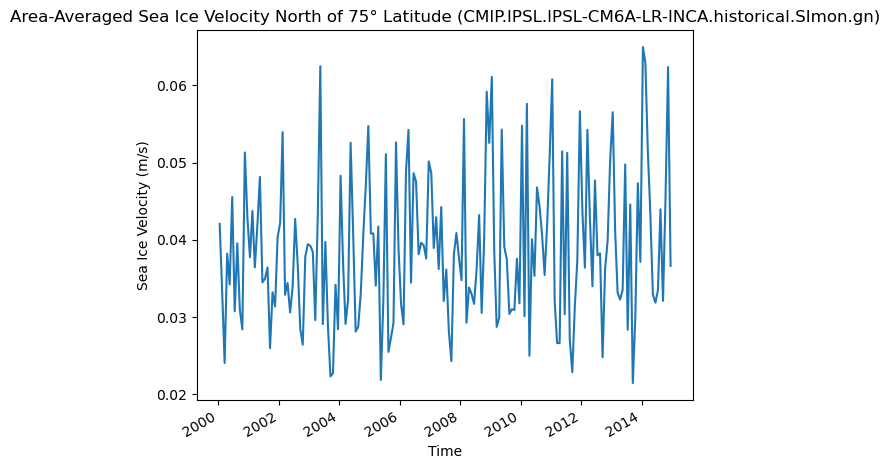

Processing model: CMIP.IPSL.IPSL-CM5A2-INCA.historical.SImon.gn
Variables not found in model
Processing model: CMIP.NUIST.NESM3.historical.SImon.gn


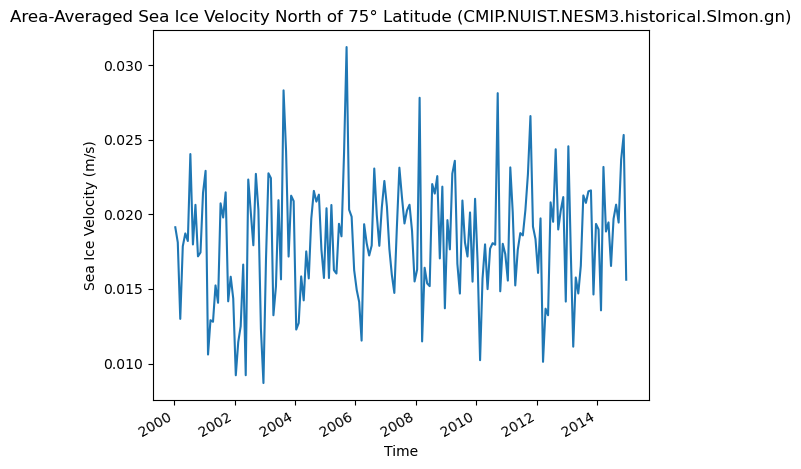

Processing model: CMIP.SNU.SAM0-UNICON.historical.SImon.gn


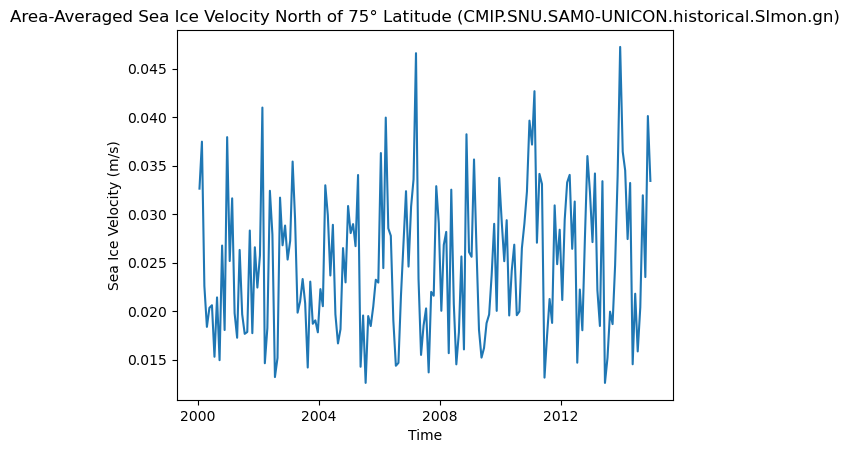

Processing model: CMIP.CMCC.CMCC-CM2-HR4.historical.SImon.gn


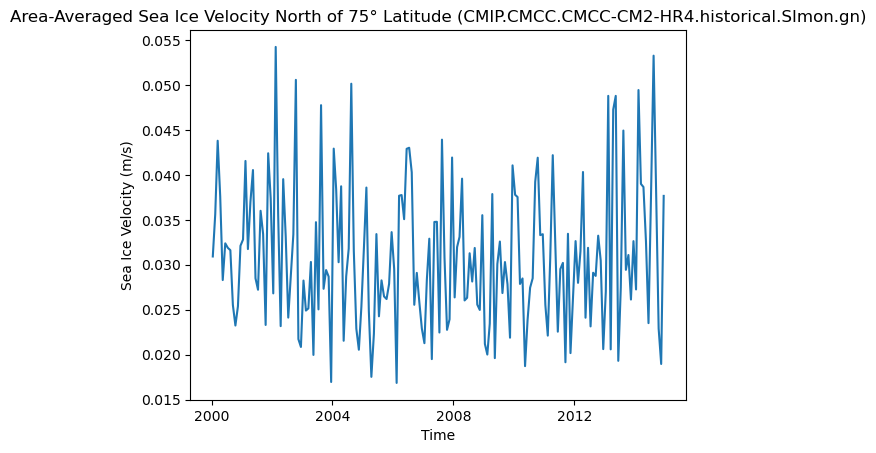

Processing model: CMIP.CCCma.CanESM5.historical.SImon.gn


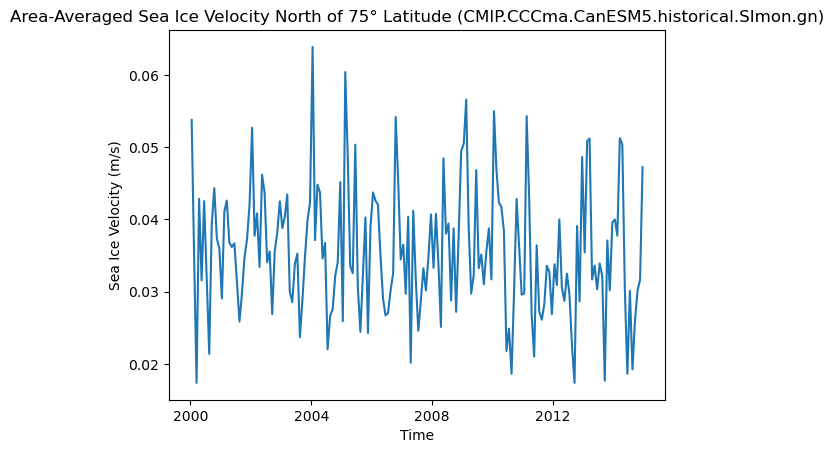

Processing model: CMIP.IPSL.IPSL-CM6A-LR.historical.SImon.gn


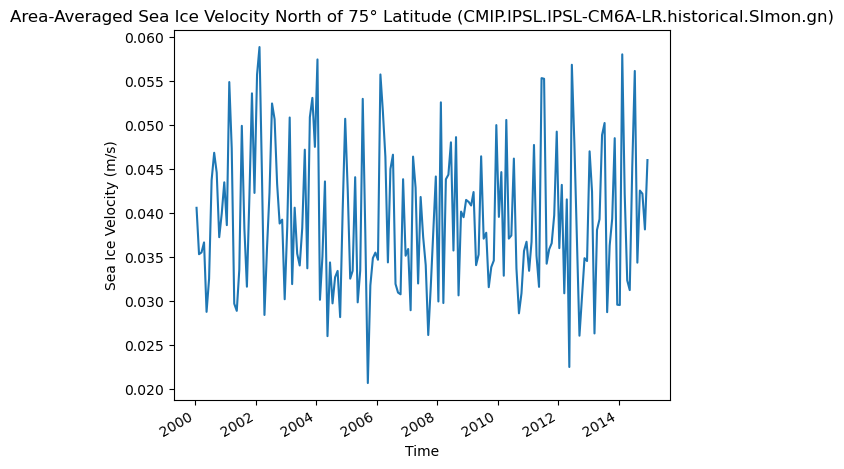

Processing model: CMIP.AS-RCEC.TaiESM1.historical.SImon.gn
Variables not found in model
Processing model: CMIP.MPI-M.ICON-ESM-LR.historical.SImon.gn
No coordinate match
Processing model: CMIP.MPI-M.MPI-ESM1-2-HR.historical.SImon.gn


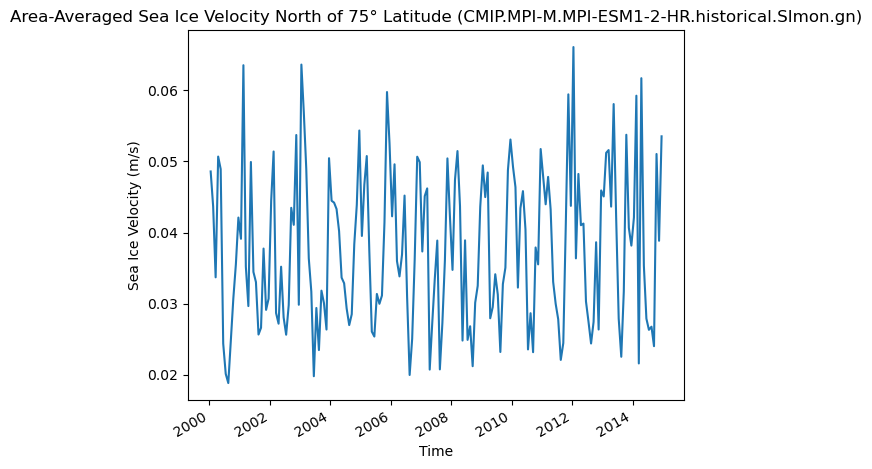

Processing model: CMIP.AWI.AWI-ESM-1-1-LR.historical.SImon.gn
No coordinate match
Processing model: CMIP.CSIRO.ACCESS-ESM1-5.historical.SImon.gn


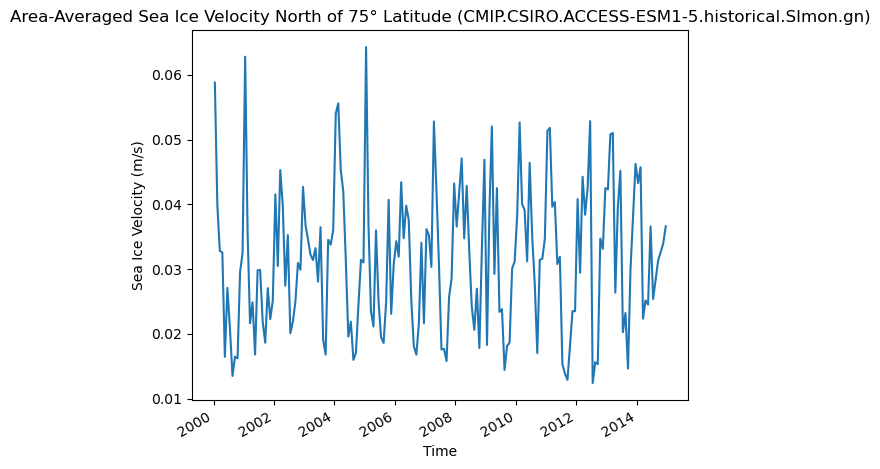

Processing model: CMIP.NCC.NorCPM1.historical.SImon.gn
Variables not found in model
Processing model: CMIP.NCC.NorESM2-LM.historical.SImon.gn
Variables not found in model
Processing model: CMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.historical.SImon.gn


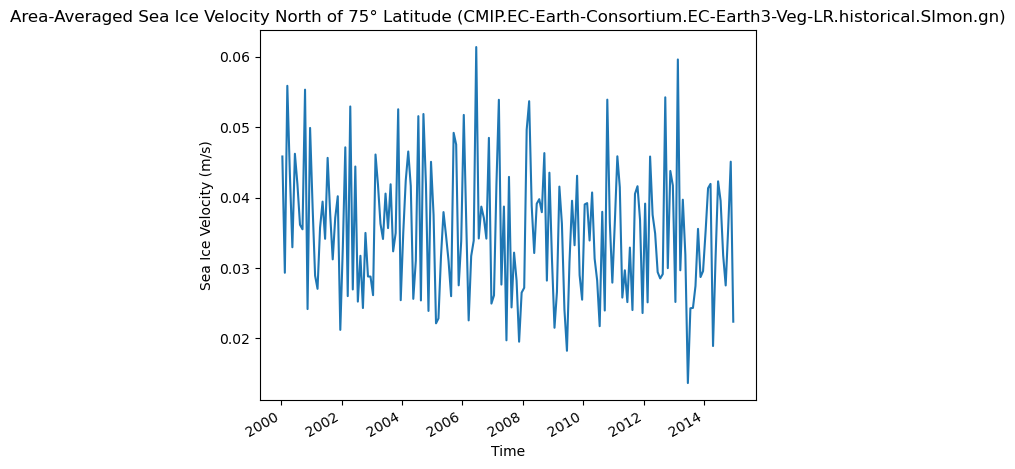

Processing model: CMIP.AWI.AWI-CM-1-1-MR.historical.SImon.gn
No coordinate match
Processing model: CMIP.THU.CIESM.historical.SImon.gn


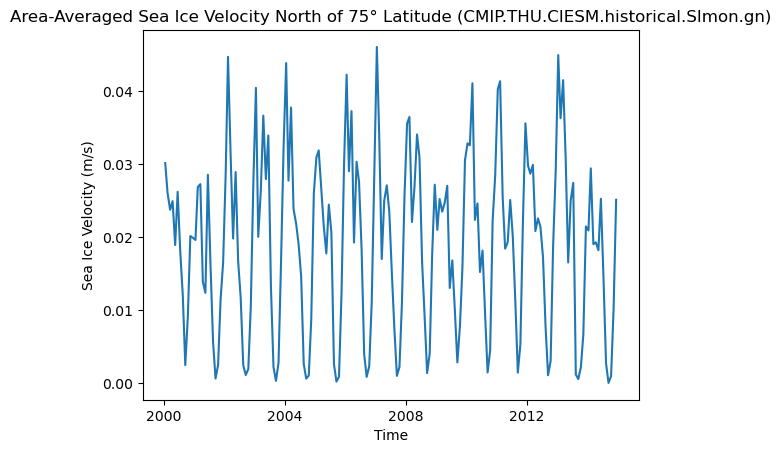

Processing model: CMIP.MIROC.MIROC6.historical.SImon.gn


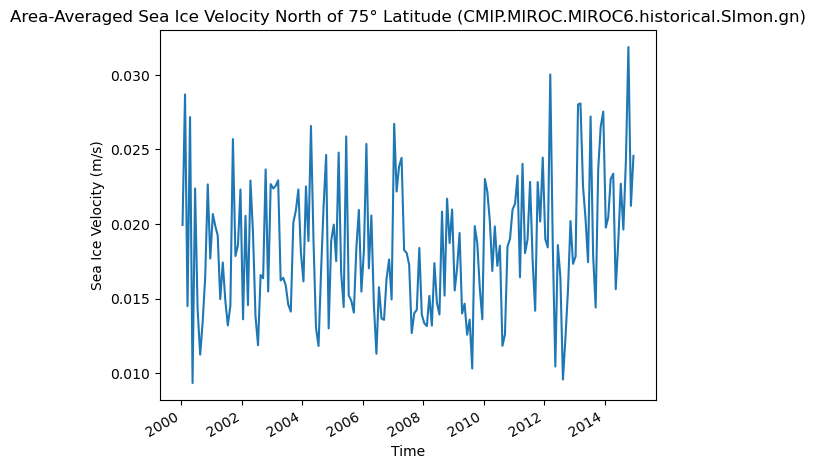

Processing model: CMIP.CAMS.CAMS-CSM1-0.historical.SImon.gn


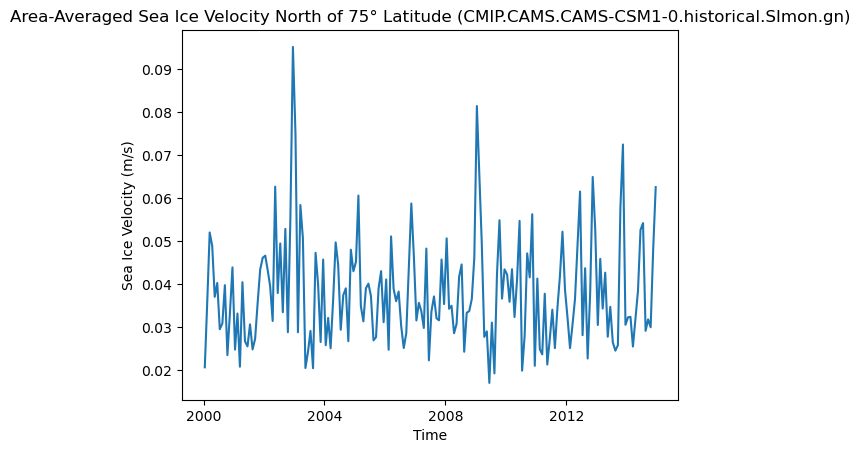

Processing model: CMIP.NCAR.CESM2-WACCM-FV2.historical.SImon.gn


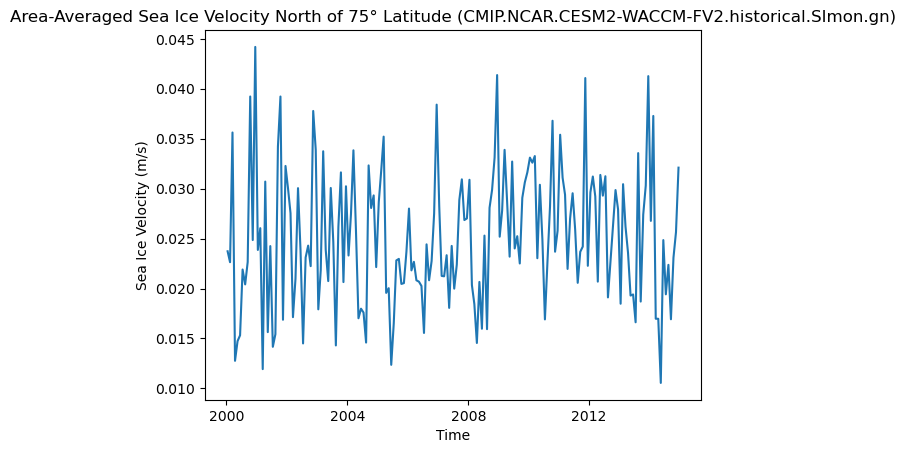

Processing model: CMIP.NOAA-GFDL.GFDL-CM4.historical.SImon.gn


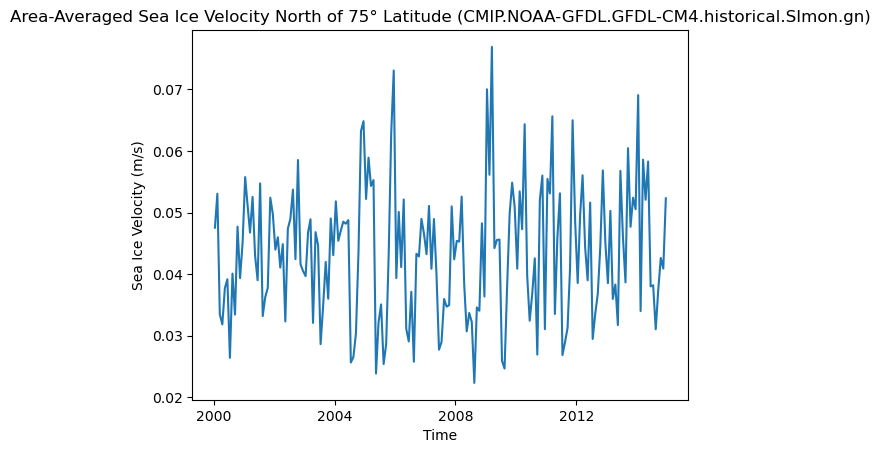

Processing model: CMIP.CMCC.CMCC-CM2-SR5.historical.SImon.gn


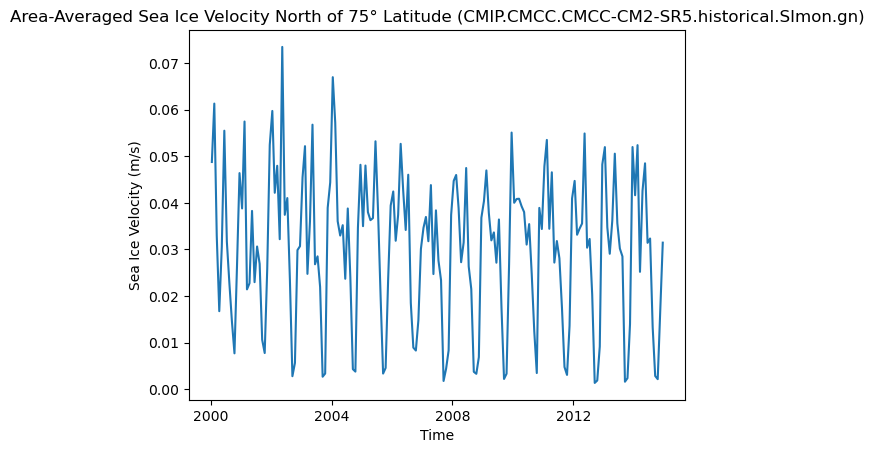

Processing model: CMIP.BCC.BCC-ESM1.historical.SImon.gn
hello


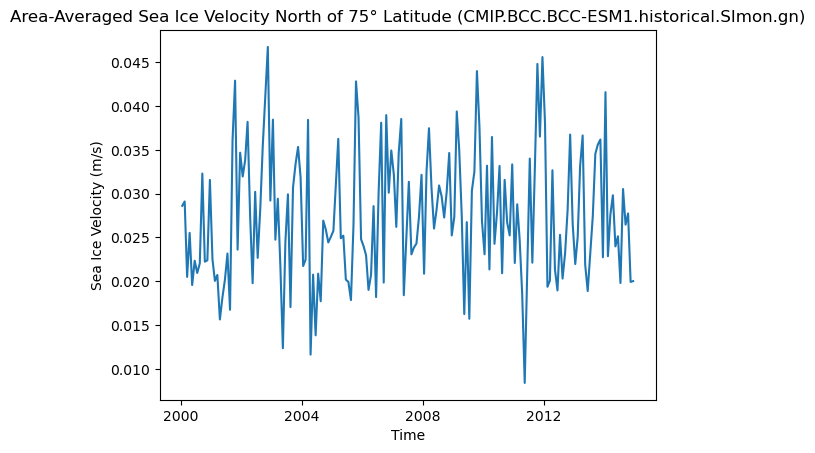

Processing model: CMIP.BCC.BCC-CSM2-MR.historical.SImon.gn
hello


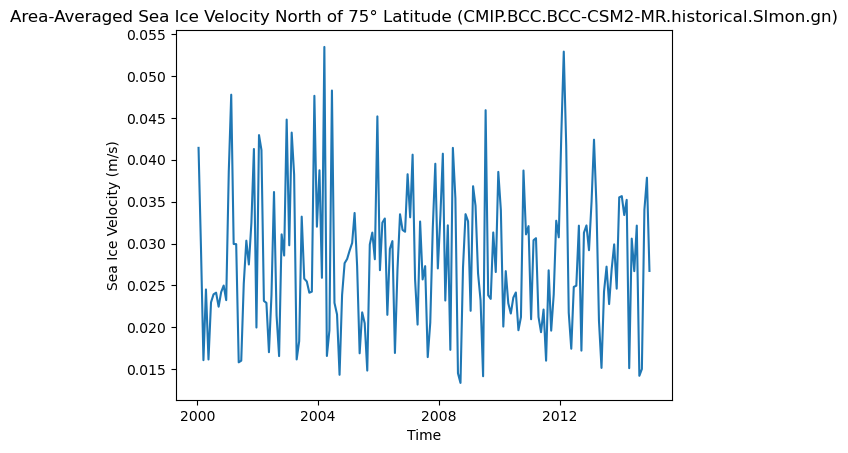

Processing model: CMIP.NCAR.CESM2-FV2.historical.SImon.gn


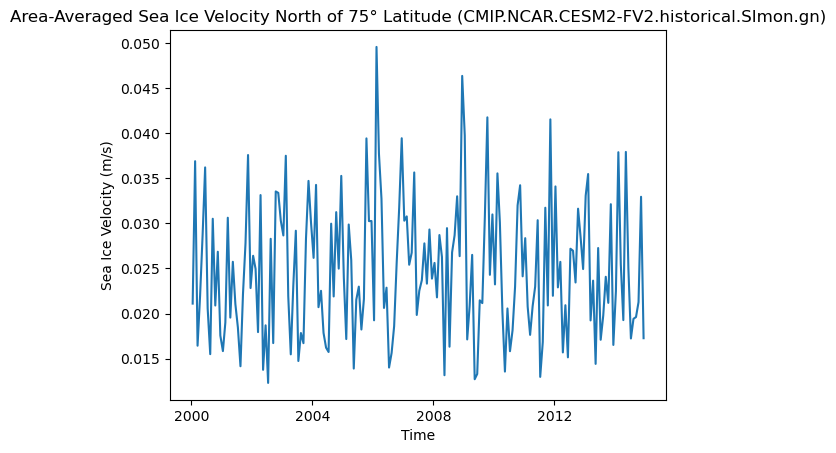

Processing model: CMIP.NCAR.CESM2-WACCM.historical.SImon.gn


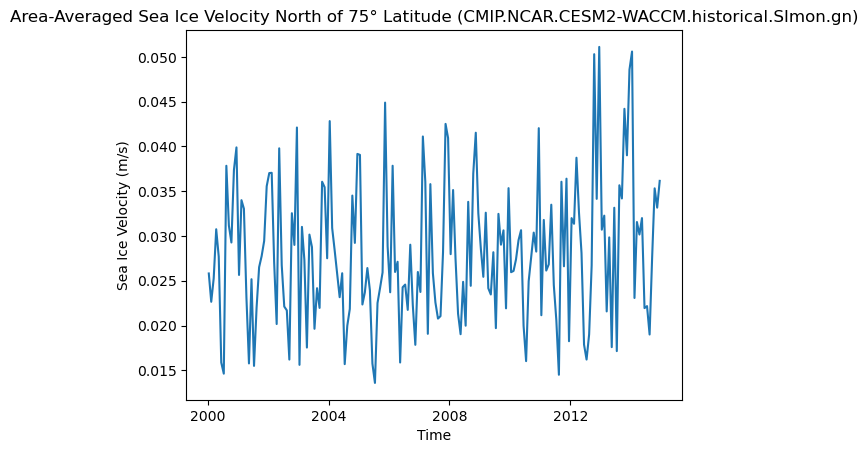

Processing model: CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.SImon.gn


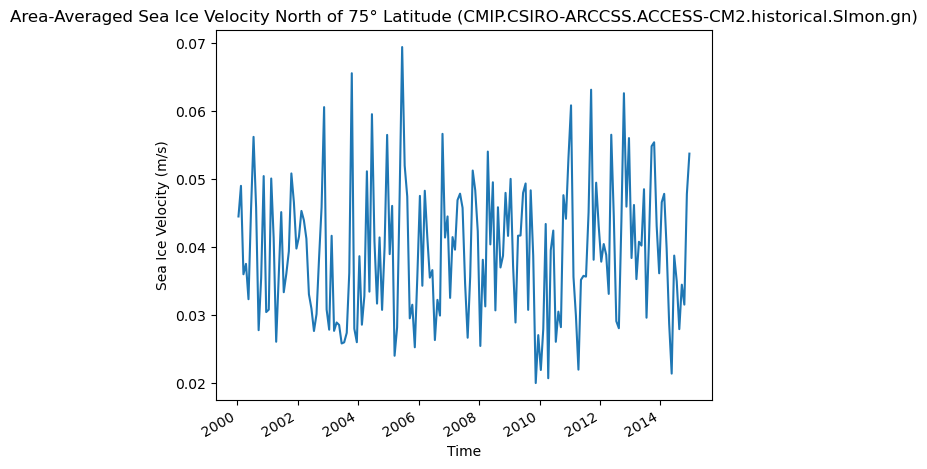

Processing model: CMIP.CMCC.CMCC-ESM2.historical.SImon.gn


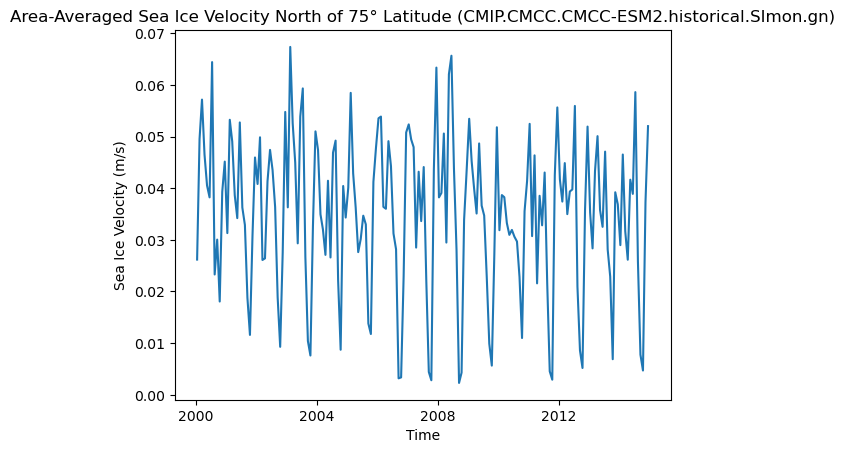

Processing model: CMIP.HAMMOZ-Consortium.MPI-ESM-1-2-HAM.historical.SImon.gn


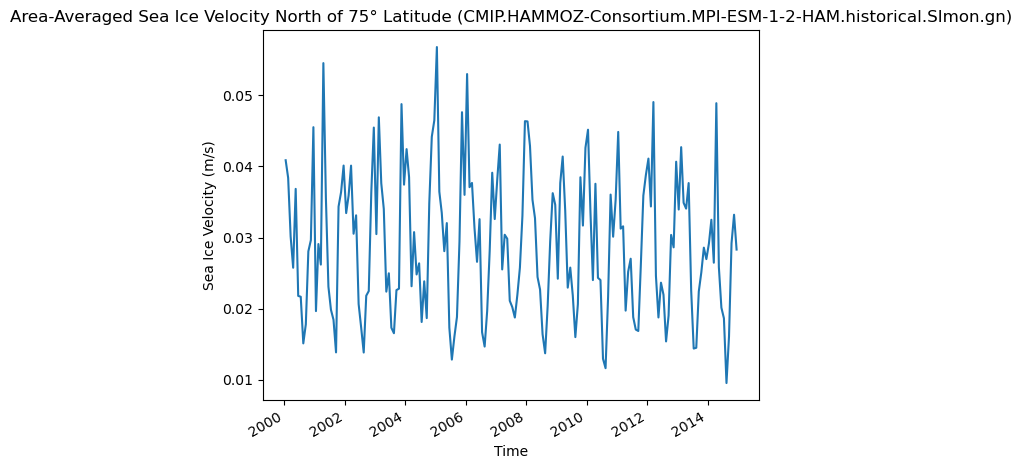

Processing model: CMIP.NOAA-GFDL.GFDL-ESM4.historical.SImon.gn


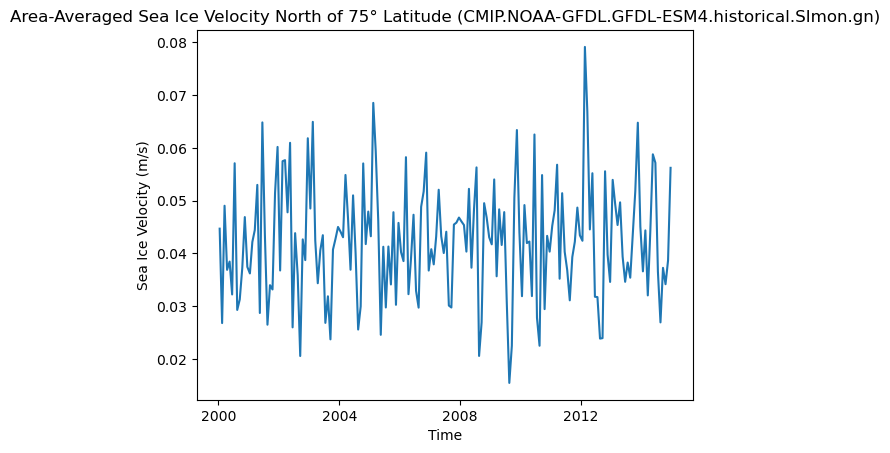

Processing model: CMIP.CAS.FGOALS-g3.historical.SImon.gn


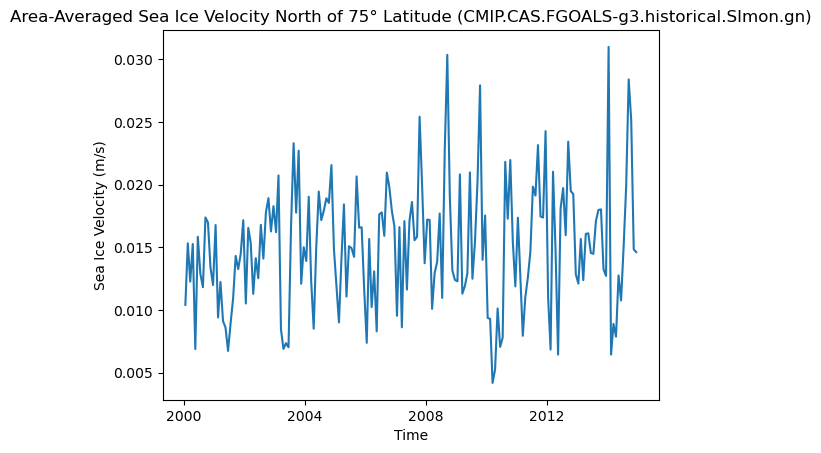

Processing model: CMIP.NCAR.CESM2.historical.SImon.gn


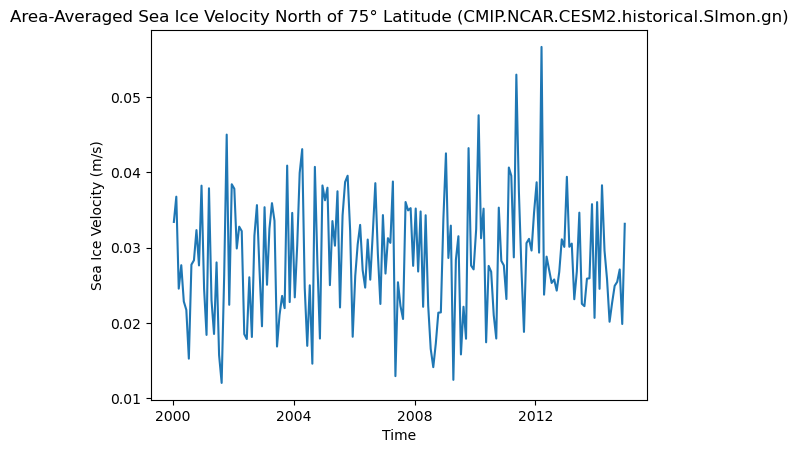

Processing model: CMIP.MPI-M.MPI-ESM1-2-LR.historical.SImon.gn


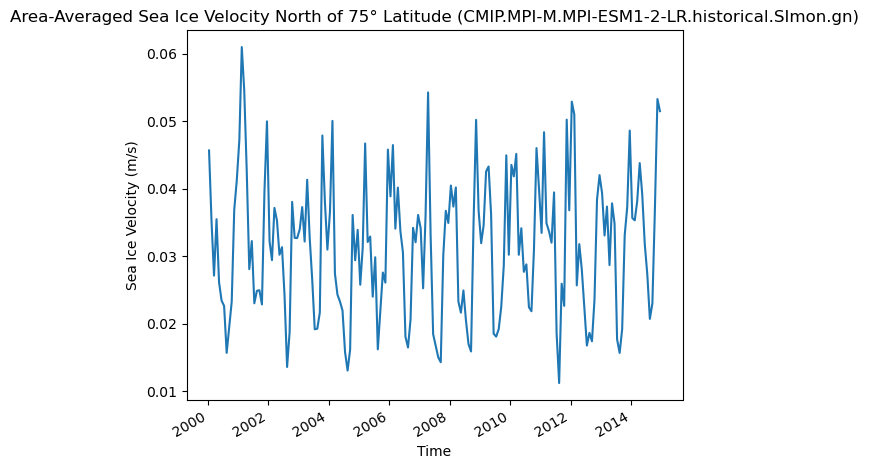

Processing model: CMIP.NCC.NorESM2-MM.historical.SImon.gn
Variables not found in model
Processing model: CMIP.MRI.MRI-ESM2-0.historical.SImon.gn
Variables not found in model
Processing model: CMIP.NASA-GISS.GISS-E2-1-G.historical.SImon.gn
hello
Variables not found in model
Processing model: CMIP.CAS.FGOALS-f3-L.historical.SImon.gn
Variables not found in model
Processing model: CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.SImon.gn


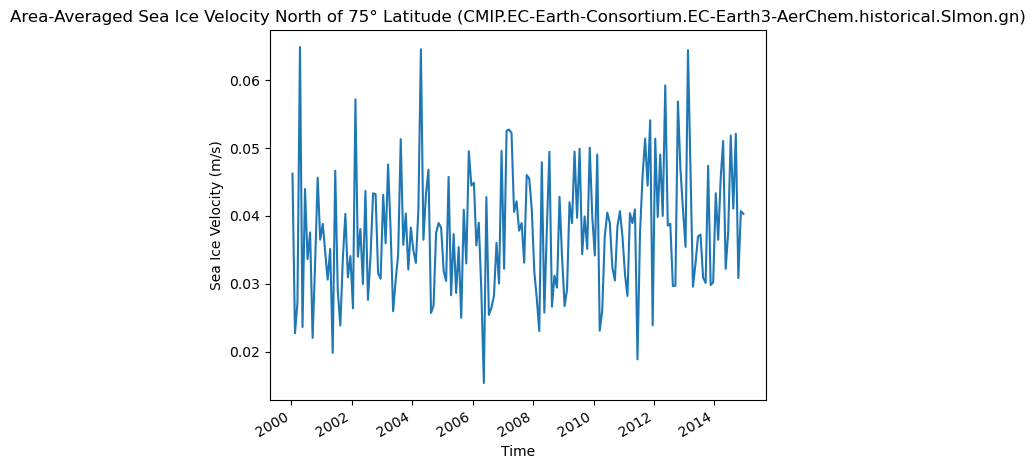

Processing model: CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical.SImon.gn


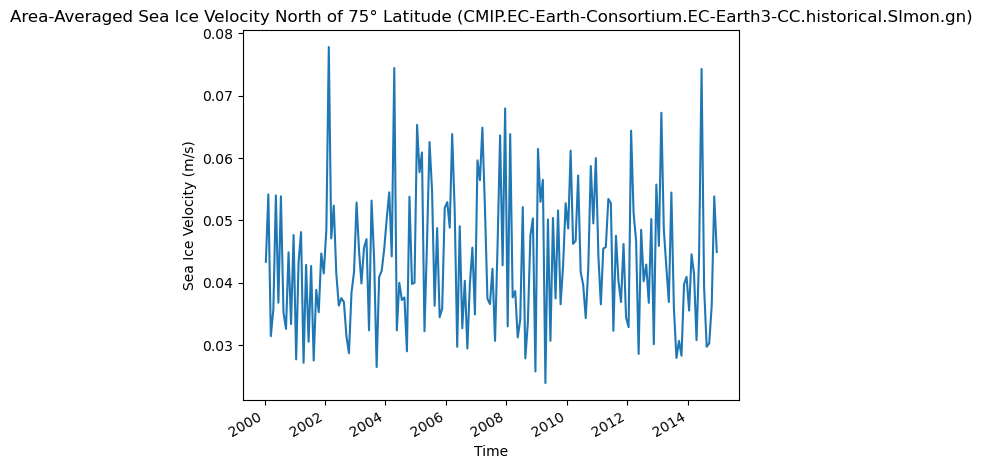

Processing model: CMIP.FIO-QLNM.FIO-ESM-2-0.historical.SImon.gn


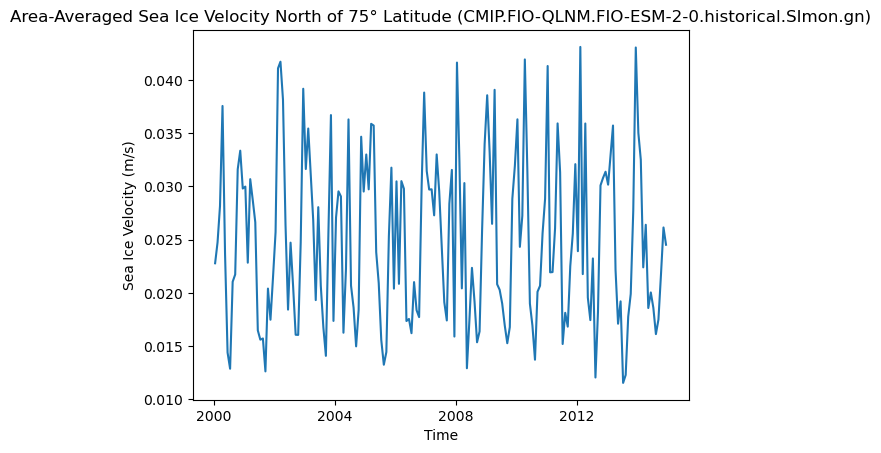

Processing model: CMIP.EC-Earth-Consortium.EC-Earth3.historical.SImon.gn


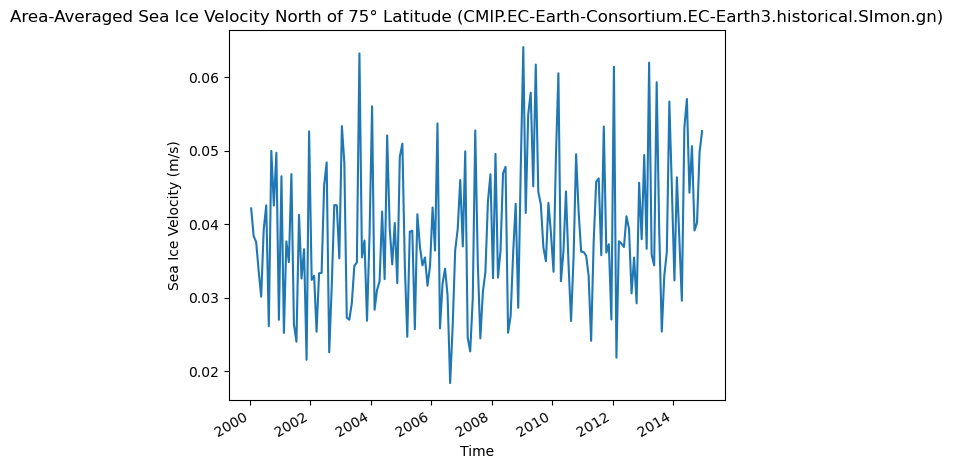

Processing model: CMIP.CAS.CAS-ESM2-0.historical.SImon.gn


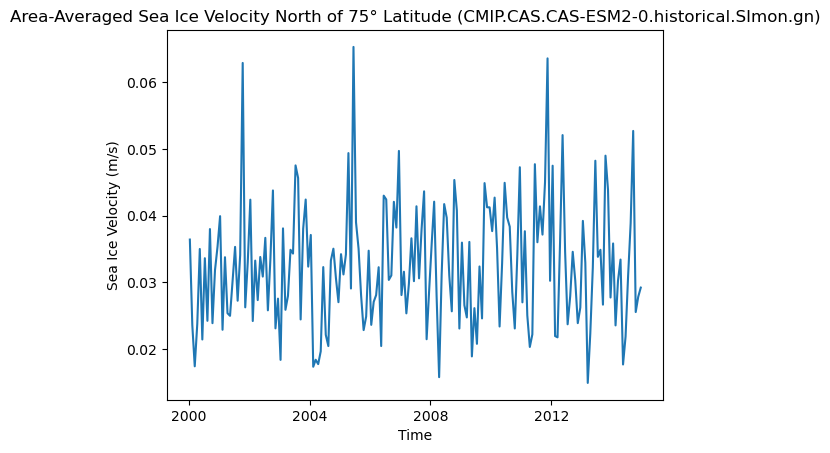

In [23]:
for model_name, ds in dset_dict.items():
    print(f"Processing model: {model_name}")

    # time filter
    time = ds['time'].data
    if isinstance(time[0], cftime.datetime):
        time_mask = time >= cftime.DatetimeNoLeap(2000, 1, 1)
    else:
        time_mask = time >= np.datetime64('2000-01-01')

    ds_filtered_time = ds.sel(time=time_mask)

    # Check coordinates
    if ('lat' in ds.dims and 'lon' in ds.dims):  # (lat, lon)
        lat = ds.lat
        spatial_dims = ['lat', 'lon']
        print('hello')
        
    elif ('y' in ds.dims and 'x' in ds.dims):  # (y, x)
        if 'lat' in ds_filtered_time:
            lat = ds.lat
        elif 'nav_lat' in ds_filtered_time:  # nav_lat # don't call ds_filtered_time.data_vars
            lat = ds.nav_lat
        elif 'latitude' in ds_filtered_time:  # latitude
            lat = ds.latitude
        spatial_dims = ['y', 'x']

    elif ('j' in ds.dims and 'i' in ds.dims):  # (j, i)
        if 'lat' in ds_filtered_time:
            lat = ds.lat
        elif 'nav_lat' in ds_filtered_time:  # nav_lat 
            lat = ds.nav_lat
        elif 'latitude' in ds_filtered_time:  # latitude 
            lat = ds.latitude
        spatial_dims = ['j', 'i']

    elif ('nj' in ds.dims and 'ni' in ds.dims):  # (nj, ni)
        if 'lat' in ds_filtered_time:
            lat = ds.lat
        elif 'nav_lat' in ds_filtered_time:  # nav_lat 
            lat = ds.nav_lat
        elif 'latitude' in ds_filtered_time:  # latitude 
            lat = ds.latitude
        spatial_dims = ['nj', 'ni']

    else:
        print('No coordinate match')
        continue 

    # latitude filter
    lat = lat.compute()
    mask = lat >= 75
    ds_north_75 = ds_filtered_time.where(mask, drop=True)

    if 'siu' in ds_north_75.data_vars and 'siv' in ds_north_75.data_vars and 'siconc' in ds_north_75.data_vars:
        condition = (
            (ds_north_75['siconc'] > 0) &  
            (ds_north_75['siu'] != 0) &   
            (ds_north_75['siv'] != 0)    
        )
        condition = condition.compute()
        ds_filtered = ds_north_75.where(condition, drop=True)
        # print(ds_filtered)

        # sea ice velocity magnitude
        velocity_magnitude = np.sqrt(ds_filtered['siu']**2 + ds_filtered['siv']**2)

        # 'area'
        if 'area' in ds_filtered:
            area = ds_filtered['area']
        else:
            area = xr.ones_like(velocity_magnitude)

        # area-weighted sea ice velocity
        area_weighted_velocity = (
            (velocity_magnitude * area).sum(dim=spatial_dims) /
            area.sum(dim=spatial_dims)
        )
        # print(area_weighted_velocity)

        # Plot
        area_weighted_velocity.plot()
        plt.title(f'Area-Averaged Sea Ice Velocity ({model_name})')
        plt.ylabel('Sea Ice Velocity (m/s)')
        plt.xlabel('Time')
        plt.show()

    else:
        print('Variables not found')